線形回帰のパートを終えたなら一番難しい部分は終わった（そりゃそーだ
- どうデータを操作する不法
- 計算グラフをその場で生成する方法、導関数を出す方法
- 損失関数、モデルのたてかた、オプティマイザの書き方

もう後は大体同じ、違うのはデータの量とモデルの複雑さ  
1,2年で新しいオプティマイザ（ hipterってなんやねんhipterって）が出てくるが、大元はSGD

次にやるのは数字の分類、多クラスロジスティック回帰…ソフトマックス回帰や多項回帰として知られるもの

In [1]:
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

In [2]:
ctx = mx.cpu()  # コンテクスト、GPUがあるならそっちでもいいよとのこと

# The MNIST dataset
28*28の白黒手書き画像を10種に分類  
最初にMXNetのユーティリティでデータ取得

In [3]:
mnist = mx.test_utils.get_mnist()  #　バイナリでとってくる？

4つのキーからなるオブジェクトがこれで手に入る: `train_data`, `train_label`, `test_data`, `test_label`  > train-rabelになってる

In [4]:
image = mnist['train_data'][0]
print(image.shape)

(1, 28, 28)


各画像は3つのタプルからなっている（channel, height, width）  
これがカラーだと、channelが3つの要素になる(RGB)　　

ラベルのチェックもできる

In [5]:
label = mnist['train_label'][0]
print(label)

5


機械学習のライブラリは一般的に画像を(batch, channel, height, width)のフォーマットで扱う  
一方で大半の画像処理のライブラリは(height, width channel)の順  
こちらの形に変換する　

In [6]:
im = np.tile(image.transpose(1,2,0),(1,1,3))  
# transpose(1,2,0): この場合配列要素を1,2,0の順に（今回channel, height, width=>height, width, channel）
# np.tile(array, (1,1,3)): arrayをもとに1回、１回、３回リピートして生成
print(im.shape)

(28, 28, 3)


> 参考

In [7]:
a = np.array([[[0,1,2],[3,4,5],[6,7,8]],[[9,10,11],[12,13,14],[15,16,17]]])
print(a)
print(a.transpose(1,2,0))

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]]
[[[ 0  9]
  [ 1 10]
  [ 2 11]]

 [[ 3 12]
  [ 4 13]
  [ 5 14]]

 [[ 6 15]
  [ 7 16]
  [ 8 17]]]


この例だと14は(1,2,3)。これをtranspose(1,2,0)すると(2,3,1)へと来る

取得したMNISTのデータは
- 一番大きな枠組みがチャネル [R,G,B]
- その中にheight: Rの中を見ると[[...],[...],[...]]
- その中にwidth: [...]

一方画像処理は
- 一番大きな枠組みがheight [[...],[...],[...]]
- その次にwidth: [...]
- その中にchannel: 一つの . が[R,G,B]
(文字だとわかりづらいな……)

tile()で3回リピートすることでRGBを満たすようにしている。

描画すると

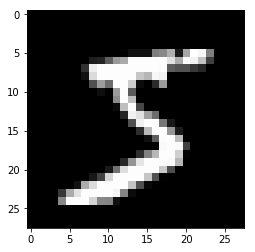

In [8]:
import matplotlib.pyplot as plt
plt.imshow(im)
plt.show() # ここもチュートリアルリンク途切れてる

# Load the data iterator
イテレータにロードする、これで楽ができる

In [9]:
batch_size = 64
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'])

トレーニングした後にテストデータへのモデル適用を行う、さもないとみんな知ってる通り、モデルは馬鹿げたことをしだす：トレーニングのデータを覚えてただ単にラベルを吐き出すだけ（過学習のことを言いたいのかな

In [10]:
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size, shuffle=True)

# Allocate model parameters
モデルの定義、今回はマルチモーダルな部分は捨てて単に1Dベクトル: 28*28=784 のコンポーネントとして見る  
多クラス分類なので入力Xに対して確率を求める必要がある  
$$
P(Y=c|X)
$$
784の入力に対し、出力は10クラスなので784*10の行列へ落とす  
オフセット（バイアスb）は要素10のベクトル

In [11]:
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

これまでのように、MXNetにトレーニングの時に自動で勾配を求められるよう宣言しておく

In [12]:
for param in params:
    param.attach_grad()

# Multiclass logistic regression
今回はクラス分類、Xを一つのLへと結びつけたい  
基本的な考え方はXを10個の異なる実数値(`y_linear`)へとマッピングする  
これをする前に、アウトプットを正の値かつ合計値を１へとノーマライズする  
この正規化によりyhatを明確な確率分布へとすることができる

In [13]:
def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear))
    partition = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

In [14]:
# テスト
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[ 0.01466005  0.03104205  0.09487285  0.11615293  0.07316667  0.01516553
   0.44094777  0.08199082  0.0917872   0.04021411]
 [ 0.0309542   0.07588483  0.37230074  0.03313261  0.0499984   0.13276106
   0.14566724  0.02354518  0.08515968  0.05059606]]
<NDArray 2x10 @cpu(0)>


In [15]:
# 合計値が1になるかの確認
print(nd.sum(sample_yhat, axis=1))


[ 1.  1.]
<NDArray 2 @cpu(0)>


# Define the model
モデルの定義

In [16]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

# The cross-entropy loss function
確率分布による予測でも意味をなす損失関数を定義する必要がある  
最も有名なものはクロスエントロピー関数、回帰よりもあいまいなため  
基本的な考え方はターゲットYをOne hot ベクトルとする: [0,1,0,0,0,0,0,0,0,0]　　
これに対しどのくらい予測がマッチしてるかを数値化する  

In [17]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

# Optimizer
同様にSGDを利用する

In [18]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

# Write evaluation loop to calculate accuracy
クロスエントロピーは素晴らしい一方で、人間の評価の方法とは違う  
正解/総数で評価するのが直感的

In [19]:
def evaluate_accracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data = batch.data[0].as_in_context(ctx).reshape((-1, 784))
            label = batch.label[0].as_in_context(ctx)
            label_one_hot = nd.one_hot(label, 10)
            output = net(data)
        
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        # print(numerator)
        # print(denominator)
    return (numerator / denominator).asscalar()

この下の計算はモデルをランダムに初期化しているので、また大雑把に1/10がそれぞれのクラスに属しているので、.10程度の正確さになるはず

In [ ]:
evaluate_accracy(test_data, net)

0.079518311

# Execute training loop

In [ ]:
epochs = 10
moving_loss = 0.

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        with autograd.record():
            data = batch.data[0].as_in_context(ctx).reshape((-1, 784))
            label = batch.label[0].as_in_context(ctx)
            label_one_hot = nd.one_hot(label, 10)
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
            loss.backward()
        SGD(params, .001)
        
        
        if i == 0:
            moving_loss = np.mean(loss.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(loss.asnumpy()[0])
    
    # if i % 100 == 0:
    test_accuracy = evaluate_accracy(test_data, net)
    train_accuracy = evaluate_accracy(train_data, net)
    print('Epoch {}. Loss: {}, Train_acc {}, Test_acc {}'.format(e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.069163068443787, Train_acc 0.7559666633605957, Test_acc 0.765625
Epoch 1. Loss: 0.818766257592281, Train_acc 0.8120166659355164, Test_acc 0.8165804147720337
Epoch 2. Loss: 0.7232531520508161, Train_acc 0.8353999853134155, Test_acc 0.8422571420669556
Epoch 3. Loss: 0.6655948173852412, Train_acc 0.8493833541870117, Test_acc 0.8548964858055115
Epoch 4. Loss: 0.6248071246817911, Train_acc 0.8582000136375427, Test_acc 0.8640525341033936
Epoch 5. Loss: 0.5928520107833193, Train_acc 0.8641999959945679, Test_acc 0.8712181448936462
Epoch 6. Loss: 0.5660860122476415, Train_acc 0.8694833517074585, Test_acc 0.875199019908905
